In [32]:
!nvidia-smi

Tue Jul  4 04:51:50 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.47                 Driver Version: 531.68       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080 L...    On | 00000000:01:00.0 Off |                  N/A |
| N/A   63C    P8               10W /  N/A|   2707MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [33]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/KnightChaser/ML-challenge/main/EX_challenging_problems/03_power_consumption_prediction/TetuanCityPowerConsumption.csv")             # UPLOADED
print(df)

# EDA Processes has been abbreviated as much as possible due to duplication.

       Temperature  Humidity  Wind Speed  general diffuse flows  \
0            6.559      73.8       0.083                  0.051   
1            6.414      74.5       0.083                  0.070   
2            6.313      74.5       0.080                  0.062   
3            6.121      75.0       0.083                  0.091   
4            5.921      75.7       0.081                  0.048   
...            ...       ...         ...                    ...   
52411        7.010      72.4       0.080                  0.040   
52412        6.947      72.6       0.082                  0.051   
52413        6.900      72.8       0.086                  0.084   
52414        6.758      73.0       0.080                  0.066   
52415        6.580      74.1       0.081                  0.062   

       diffuse flows  Zone 1 Power Consumption  
0              0.119               34055.69620  
1              0.085               29814.68354  
2              0.100               29128.10127  

In [34]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

train_dataset = df.sample(frac = 0.8, random_state = 0xCAFE)
test_dataset  = df.drop(train_dataset.index)

# The prdiction objective of the current model
train_target = train_dataset.pop("Zone 1 Power Consumption")
test_target  = test_dataset.pop("Zone 1 Power Consumption")

ss = StandardScaler()

ss.fit(train_dataset)
train_scaled = ss.transform(train_dataset)
test_scaled  = ss.transform(test_dataset)

print(train_scaled.shape)
print(train_target.shape)

(41933, 5)
(41933,)


In [35]:
from tensorflow import keras

def create_CNN_model(additional_layers = None):

    model = keras.Sequential()

    if additional_layers:
        for more_layer in additional_layers:
            model.add(more_layer)

    model.add(keras.layers.Dense(units = 1, activation = "relu"))        # regression

    return model

In [39]:
model = create_CNN_model([
    keras.layers.Conv1D(16, kernel_size = 2,                                    # Convolution (1D)
                            activation  = "relu",
                            padding     = "same",
                            input_shape = (train_scaled.shape[1], 1)),
    keras.layers.MaxPooling1D(pool_size = 2),
    keras.layers.Conv1D(32, kernel_size = 3,                                    # Convolution (1D)
                            activation  = "relu",
                            padding     = "same"),
    keras.layers.MaxPooling1D(pool_size = 2),
    keras.layers.Flatten(),
    keras.layers.Dense(units = 1024, activation = "relu"),
    keras.layers.Dense(units = 512),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(units = 128),
    keras.layers.Dense(units = 64),
    keras.layers.Dense(units = 32),
    keras.layers.Dense(units = 16),
])

print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 5, 16)             48        
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 2, 16)            0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 2, 32)             1568      
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 1, 32)            0         
 g1D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 32)                0         
                                                                 
 dense_75 (Dense)            (None, 1024)            

In [40]:
from sklearn.utils import validation

model.compile(loss = "mse",            # <--- REGRESSION
              metrics = "mae",
              optimizer = "adam")

early_stopping_checkpoint = keras.callbacks.EarlyStopping(patience = 20, restore_best_weights = True, mode = "auto")
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', save_best_only = True)


history = model.fit(train_scaled, train_target,
                    epochs = 1000,
                    steps_per_epoch = 200,
                    validation_data = (test_scaled, test_target),
                    callbacks = [early_stopping_checkpoint, checkpoint_cb])

Epoch 1/1000
200/200 [==============================] - 5s 14ms/step - loss: 200909504.0000 - mae: 10262.0469 - val_loss: 47970300.0000 - val_mae: 5809.8491
Epoch 2/1000
200/200 [==============================] - 2s 10ms/step - loss: 45748044.0000 - mae: 5586.6841 - val_loss: 42358340.0000 - val_mae: 5355.8911
Epoch 3/1000
200/200 [==============================] - 2s 10ms/step - loss: 42559444.0000 - mae: 5319.3027 - val_loss: 40380412.0000 - val_mae: 5188.4795
Epoch 4/1000
200/200 [==============================] - 2s 10ms/step - loss: 41216124.0000 - mae: 5197.8374 - val_loss: 39510520.0000 - val_mae: 5116.3765
Epoch 5/1000
200/200 [==============================] - 2s 10ms/step - loss: 40410968.0000 - mae: 5119.4351 - val_loss: 38864416.0000 - val_mae: 4999.1440
Epoch 6/1000
200/200 [==============================] - 2s 11ms/step - loss: 39800264.0000 - mae: 5062.5068 - val_loss: 38255624.0000 - val_mae: 4988.2651
Epoch 7/1000
200/200 [==============================] - 2s 11ms/step

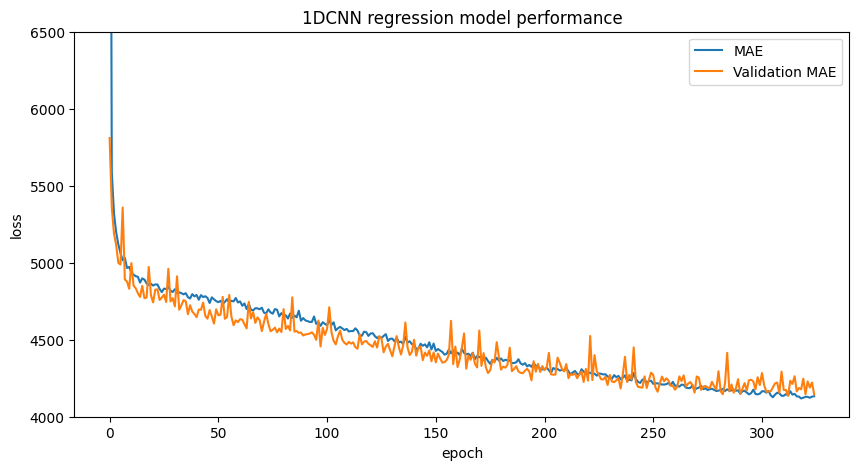

In [41]:
import matplotlib.pyplot as plt

plt.title("1DCNN regression model performance")

plt.plot(history.history["mae"], label = "MAE")
plt.plot(history.history["val_mae"], label = "Validation MAE")

# plt.ylim([min(min(history.history["mae"]), min(history.history["val_mae"])) - 1000, max(max(history.history["mae"]), max(history.history["val_mae"])) + 1000])
plt.ylim([4000, 6500])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

fig = plt.gcf()
fig.set_size_inches(10, 5)

plt.show()

In [42]:
model.evaluate(test_scaled, test_target)

328/328 [==============================] - 1s 5ms/step - loss: 30302070.0000 - mae: 4165.0713


[30302070.0, 4165.0712890625]

328/328 [==============================] - 1s 3ms/step


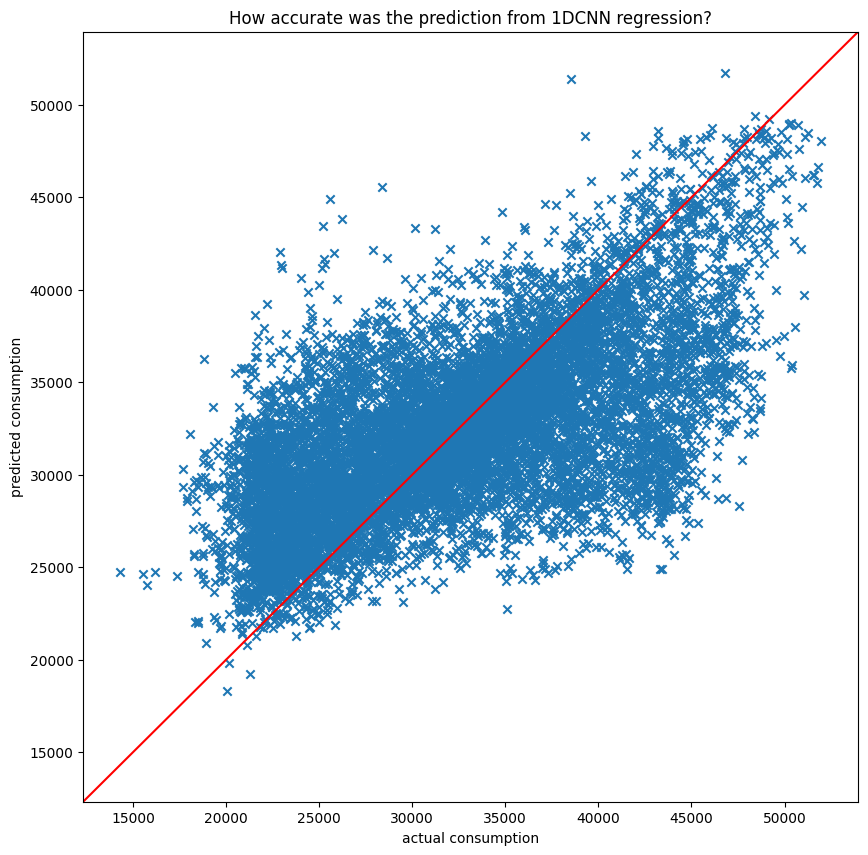

In [43]:
# Prediction Visualization
prediction = model.predict(test_scaled)

plt.figure(figsize = (10, 10))


plt.scatter(test_target, prediction, marker = "x")

plt.title("How accurate was the prediction from 1DCNN regression?")
plt.xlabel("actual consumption")
plt.ylabel("predicted consumption")

# axis_range = [10000, 50000]
axis_range = [min(min(test_target), min(prediction)) - 2000, max(max(test_target), max(prediction)) + 2000]
plt.plot(axis_range, axis_range, linestyle = "solid", color = "red")
plt.xlim(axis_range)
plt.ylim(axis_range)

plt.show()

# If the scattered plots more nearly approximates to the red diagonal line which represents the exact
# ratio of 1:1 for prediction:real, the model performed better.